In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from shGLM_class import shGLM
from sklearn import metrics

# Hyperparams

In [2]:
train_T = 20000
test_T = 8000
W_size = 251
C_den = torch.tensor([0,1,1,1,1])
sub_no = C_den.shape[0]

batch_size = 2094

#syn_basis_tau = torch.logspace(0,np.log(25),steps=5,base=np.exp(1))
#hist_basis_tau = torch.logspace(0,np.log(45),steps=5,base=np.exp(1))
syn_basis_tau = torch.tensor([5])
#hist_basis_tau = torch.logspace(1,np.log(10),steps=3,base=np.exp(1))
hist_basis_tau = torch.tensor([10])
spike_status = False
hist_T = 251

In [3]:
Ensyn = torch.tensor([0, 106, 213, 211, 99])
Insyn = torch.tensor([1, 22, 36, 42, 19])
N = torch.sum(Ensyn) + torch.sum(Insyn)
print(N)

C_syn = torch.zeros(sub_no, N)
count = 0
for m in range(sub_no):
    for e in range(Ensyn[m]):
        C_syn[m,count] = 1
        count += 1
        
for m in range(sub_no):
    for i in range(Insyn[m]):
        C_syn[m,count] = -1
        count += 1

tensor(749)


# Adjust W and C

In [6]:
E_neural = np.load("/media/hdd01/sklee/hglm/biophysical/inputs/Espikes_d48000_r1_rep1_Ne629_e5_E20_neural.npy")[:train_T]
I_neural = np.load("/media/hdd01/sklee/hglm/biophysical/inputs/Ispikes_d48000_r1_rep1_Ni120_i20_I30_neural.npy")[:train_T]
neural = np.hstack((E_neural, I_neural))

In [7]:
Delta_init = np.exp(4.5825)
K_syn_init = np.tile(np.asarray([0.1462, -0.0374]).reshape((1,-1,2)),
                                 (sub_no, 1, 1))
C_init = np.exp(2.7374)
#C_init = 30
sigma_init = 0.5

new_Theta = np.empty((sub_no))
new_C = np.ones((sub_no)) * C_init
#new_K_syn = np.empty_like(K_syn_init)
new_K_syn = K_syn_init
new_K_syn[0] *= 1

window = np.arange(W_size) - Delta_init
window[window < 0] = 0

filt_neural = np.empty((neural.shape[0], sub_no))
# filt_neural contains just the filtered synpatic inputs to each subunit
upstream_out = np.empty((neural.shape[0], sub_no))
# upstream_out contains all the inputs summed, nonlin'ed, but NOT C

In [8]:
for s in range(sub_no):
    sub_out = np.zeros((neural.shape[0]))
    e_idx = torch.where(C_syn[s] == 1)[0].numpy()
    i_idx = torch.where(C_syn[s] == -1)[0].numpy()
    
    in_e = neural[:,e_idx]
    in_i = neural[:,i_idx]
    
    kern_e = np.zeros((W_size))
    kern_i = np.zeros((W_size))
    for b in range(K_syn_init.shape[1]):
        tau = syn_basis_tau[b].item()
        t_tau = window / tau
        kern_e += np.multiply(t_tau, np.exp(-t_tau)) * K_syn_init[s,b,0]
        kern_i += np.multiply(t_tau, np.exp(-t_tau)) * K_syn_init[s,b,1]
    
    for i in range(e_idx.shape[0]):
        sub_out += np.convolve(in_e[:,i], np.flip(kern_e), mode="same")
        
    for i in range(i_idx.shape[0]):
        sub_out += np.convolve(in_i[:,i], np.flip(kern_i), mode="same")
        
    filt_neural[:,s] = sub_out

In [9]:
print(np.mean(filt_neural, 0))

[-1.64294497  0.41124093  0.92995419  0.80394787  0.32198303]


In [10]:
for s in range(sub_no):
    subunit = sub_no - 1 - s
    upstream_idx = torch.where(C_den == subunit + 1)[0].numpy()
    if upstream_idx.size == 0:
        upstream_in = np.zeros((neural.shape[0]))
    else:
        upstream_in = upstream_out[:,upstream_idx]
        
    sub_in = filt_neural[:,subunit]
    
    if upstream_idx.size > 0:
        old_sigma = np.std(sub_in + np.sum(upstream_in * new_C[upstream_idx], axis=1))
    else:
        old_sigma = np.std(sub_in)
    sigma_factor = sigma_init / old_sigma
    print(sigma_factor)
    
    if upstream_idx.size > 0:
        new_C[upstream_idx] = new_C[upstream_idx] * sigma_factor
        new_K_syn[subunit,:,:] = K_syn_init[subunit,:,:] * sigma_factor
    else:
        new_K_syn[subunit,:,:] = K_syn_init[subunit,:,:] * sigma_factor
    
    if upstream_idx.size > 0:
        comb_in = sub_in*sigma_factor + np.sum(upstream_in * new_C[upstream_idx], axis=1)
        #comb_in = sub_in + np.sum(upstream_in * new_C[upstream_idx], axis=1)
    else:
        comb_in = sub_in * sigma_factor
        #comb_in = sub_in
    new_Theta[subunit] = np.mean(comb_in)
    comb_out = 1 / (1+np.exp(-comb_in + new_Theta[subunit]))
    upstream_out[:,subunit] = comb_out

1.8485171304463937
1.056849874284975
1.141298413233613
1.5534116651488798
0.12519557487020386


In [11]:
print(new_K_syn)
print(new_C)
print(new_Theta)
print(np.mean(upstream_out, axis=0))
print(np.std(upstream_out, axis=0))

[[[ 0.01830359 -0.00468231]]

 [[ 0.22710879 -0.0580976 ]]

 [[ 0.16685783 -0.04268456]]

 [[ 0.15451145 -0.03952619]]

 [[ 0.2702532  -0.06913454]]]
[15.44677124  1.9338674   1.9338674   1.9338674   1.9338674 ]
[3.63878204 0.63882646 1.06135524 0.8496522  0.59519114]
[0.4981117  0.49700399 0.49769151 0.49663844 0.49663663]
[0.11697021 0.11445016 0.11494173 0.11049164 0.11081203]


In [12]:
np.save("/media/hdd01/sklee/shglm/biophysical/final_fit/adjusted_Delta.npy", np.log(Delta_init))
np.save("/media/hdd01/sklee/shglm/biophysical/final_fit/adjusted_Theta.npy", new_Theta)
np.save("/media/hdd01/sklee/shglm/biophysical/final_fit/adjusted_C.npy", np.log(new_C))
np.save("/media/hdd01/sklee/shglm/biophysical/final_fit/adjusted_K_syn.npy", new_K_syn)

# Train ALL Params

In [4]:
fit_shGLM = shGLM(C_den, C_syn, W_size, Ensyn,
                 syn_basis_tau, hist_basis_tau,
                 spike_status, hist_T)


V_ref = np.fromfile("/media/hdd01/sklee/hglm/biophysical/inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.bin")
V_ref = V_ref[1:-2]

train_V_ref = V_ref[:train_T]
test_V_ref = V_ref[train_T:train_T+test_T]

test_V_ref = torch.from_numpy(test_V_ref).cuda()
train_V_ref = torch.from_numpy(train_V_ref)

In [5]:
adjust_K_syn = torch.from_numpy(np.load("/media/hdd01/sklee/shglm/biophysical/final_fit/adjusted_K_syn.npy"))
adjust_Delta = torch.from_numpy(np.load("/media/hdd01/sklee/shglm/biophysical/final_fit/adjusted_Delta.npy"))
adjust_C = torch.from_numpy(np.load("/media/hdd01/sklee/shglm/biophysical/final_fit/adjusted_C.npy"))
adjust_Theta = torch.from_numpy(np.load("/media/hdd01/sklee/shglm/biophysical/final_fit/adjusted_Theta.npy"))

with torch.no_grad():
    fit_shGLM.K_syn = nn.Parameter(adjust_K_syn.float())
    fit_shGLM.Delta = nn.Parameter(adjust_Delta.float().reshape(1))
    fit_shGLM.C = nn.Parameter(adjust_C.float())
    fit_shGLM.Theta = nn.Parameter(adjust_Theta.float())
    
fit_shGLM.train().cuda()

shGLM()

In [6]:
E_neural = np.load("/media/hdd01/sklee/shglm/biophysical/inputs/Espikes_d48000_r1_rep1_Ne629_e5_E20_neural.npy")
I_neural = np.load("/media/hdd01/sklee/shglm/biophysical/inputs/Ispikes_d48000_r1_rep1_Ni120_i20_I30_neural.npy")

train_neural = np.hstack((E_neural, I_neural))[:train_T]
test_neural = np.hstack((E_neural, I_neural))[train_T:train_T + test_T]
train_neural = torch.from_numpy(train_neural)
test_neural = torch.from_numpy(test_neural).cuda()


In [7]:
repeat_no = 2
batch_no = (train_V_ref.shape[0] - batch_size) * repeat_no
train_idx = np.empty((repeat_no, train_V_ref.shape[0] - batch_size))
for i in range(repeat_no):
    part_idx = np.arange(train_V_ref.shape[0] - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

print(batch_no)
print(train_idx.shape[0])

35812
35812


In [8]:
no_spike_bool = True
spike_bool = False

fit_shGLM.V_o.requires_grad = no_spike_bool
fit_shGLM.K_syn.requires_grad = True
fit_shGLM.Delta.requires_grad = no_spike_bool
fit_shGLM.C.requires_grad= no_spike_bool
fit_shGLM.Theta.requires_grad = True

fit_shGLM.thresh.requires_grad = spike_bool
fit_shGLM.spike_size.requires_grad = spike_bool
fit_shGLM.K_hist.requires_grad = spike_bool


In [9]:
#optimizer = optim.Adam(fit_shGLM.parameters(), lr=0.01)
#optimizer = optim.Adam(fit_shGLM.parameters(), lr=0.0025)
optimizer = optim.Adam(fit_shGLM.parameters(), lr=0.001)

In [ ]:
loss_array = np.empty((batch_no))

for i in tnrange(batch_no):
    optimizer.zero_grad()
    batch_idx = train_idx[i].long()
    batch_X = train_neural[batch_idx : batch_idx+batch_size].float().cuda()
    batch_pred = fit_shGLM(batch_X)
    batch_ref = train_V_ref[batch_idx:batch_idx+batch_size].cuda()
    
    #loss = criterion(batch_ref, batch_pred)
    
    diff = (batch_ref - batch_pred) ** 1
    loss = torch.var(diff)
    loss_array[i] = loss.item()
    
    #print(i, train_score)
    
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    if i%100 == 0:
        test_pred = fit_shGLM(test_neural.float())
        #test_loss = criterion(test_V_ref, test_pred)
        test_diff = (test_V_ref - test_pred) ** 1
        test_loss = torch.var(test_diff)
        test_score = metrics.explained_variance_score(y_true=test_V_ref.cpu().detach().numpy(),
                                                      y_pred=test_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        train_score = metrics.explained_variance_score(y_true=batch_ref.cpu().detach().numpy(),
                                                      y_pred=batch_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        print("TEST", i, test_loss.item(), test_score, train_score)
        if i%500 == 0:
            torch.save(fit_shGLM.state_dict(), "/media/hdd01/sklee/shglm/biophysical/final_fit/final5_nospike_h1_shglm_i"+str(i)+".pt")
    


<ipython-input-10-f3be7d3ab77a>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(batch_no):


TEST 0 5.255364768431727 0.6194883389097455 0.458400880782628
TEST 100 4.415945501296708 0.6802660078222961 0.6305894956547689
TEST 200 4.0513300410764295 0.7066657803735584 0.6270771417874617
TEST 300 3.925113128922357 0.7158044432492823 0.725193630424746
TEST 400 3.905616281985487 0.7172161012188156 0.661537788886488
TEST 500 3.647185847128584 0.7359276081272106 0.6786782607097992
TEST 600 3.5626616074043014 0.7420475370616189 0.5897355941061982
TEST 700 3.4419457825958104 0.7507878968861543 0.5753497851409072
TEST 800 3.453553753297058 0.749947428442524 0.6513573620338433
TEST 900 3.483862130965096 0.7477529678035557 0.6495519979161402
TEST 1000 3.354593243323845 0.7571126072178801 0.5524775987757224
TEST 1100 3.367016742752511 0.7562130908756268 0.7020424496709938
TEST 1200 3.3776568533623865 0.7554426997963466 0.6718699358482567
TEST 1300 3.4320461075077646 0.7515046771403288 0.5853510046746659
TEST 1400 3.485791810118155 0.7476132504764321 0.7042819451012433
TEST 1500 3.271579846

# Test Part Fit

In [4]:
final_shGLM = shGLM(C_den, C_syn, W_size, Ensyn,
                 syn_basis_tau, hist_basis_tau,
                 spike_status, hist_T)
final_shGLM.load_state_dict(torch.load("/media/hdd01/sklee/shglm/biophysical/final_fit/final5_nospike_shglm_i11000.pt"))

final_shGLM.eval().cuda()

V_ref = np.fromfile("/media/hdd01/sklee/hglm/biophysical/inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.bin")
V_ref = V_ref[1:-2]

test_V_ref = V_ref[train_T:train_T+test_T]


In [5]:
E_neural = np.load("/media/hdd01/sklee/shglm/biophysical/inputs/Espikes_d48000_r1_rep1_Ne629_e5_E20_neural.npy")
I_neural = np.load("/media/hdd01/sklee/shglm/biophysical/inputs/Ispikes_d48000_r1_rep1_Ni120_i20_I30_neural.npy")

test_neural = np.hstack((E_neural, I_neural))[train_T:train_T + test_T]
test_neural = torch.from_numpy(test_neural).float().cuda()

test_V_final = final_shGLM(test_neural).cpu().detach().numpy()

test_V_final = test_V_final
test_V_ref = test_V_ref

0.8831894052596222


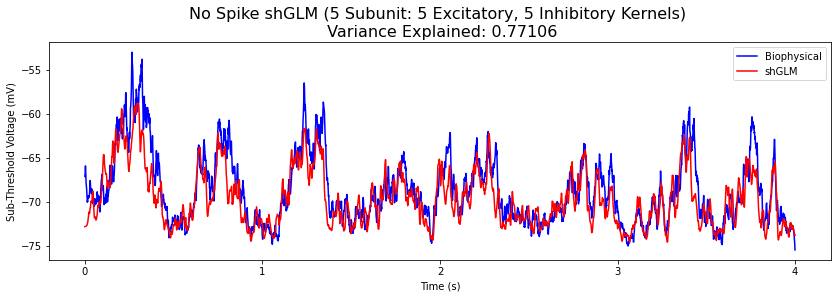

In [6]:
plt.figure(figsize = (14,4))
plt.plot(test_V_ref[:4000], label="Biophysical", c="blue")
plt.plot(test_V_final[:4000]-1.3, label="shGLM", c="red")
print(np.corrcoef(test_V_ref, test_V_final)[0][1])


test_score = metrics.explained_variance_score(y_true=test_V_ref,
                                                      y_pred=test_V_final,
                                                      multioutput='uniform_average')

plt.title("No Spike shGLM (5 Subunit: 5 Excitatory, 5 Inhibitory Kernels) \n Variance Explained: " + str(round(test_score, 5)), fontsize = 16)
#plt.xticks(np.arange(0,8001,1000),[0,1,2,3,4,5,6,7,8])
plt.xticks(np.arange(0,4001,1000),[0,1,2,3,4])
plt.xlabel("Time (s)")
plt.ylabel("Sub-Threshold Voltage (mV)")
plt.legend()
#plt.show()


plt.savefig("/media/hdd01/sklee/shglm/biophysical/final5_nospike.png", dpi=150, bbox_inches='tight')

In [7]:
for name, param in final_shGLM.named_parameters():
    if param.requires_grad:
        print(name, param.data)

V_o tensor([-76.0649], device='cuda:0')
K_syn tensor([[[ 0.0186, -0.0238]],

        [[ 0.1814, -0.0141]],

        [[ 0.2150, -0.0691]],

        [[ 0.1416, -0.0721]],

        [[ 0.1848, -0.1480]]], device='cuda:0')
Delta tensor([4.6005], device='cuda:0')
C tensor([3.0235, 0.8632, 0.8776, 1.2156, 0.8883], device='cuda:0')
Theta tensor([3.3843, 0.9971, 1.8942, 1.4188, 1.3132], device='cuda:0')
thresh tensor([85., 85., 85., 85., 85.], device='cuda:0')
spike_size tensor([4., 4., 4., 4., 4.], device='cuda:0')
K_hist tensor([[-0.0250, -0.0250, -0.0250],
        [-0.0250, -0.0250, -0.0250],
        [-0.0250, -0.0250, -0.0250],
        [-0.0250, -0.0250, -0.0250],
        [-0.0250, -0.0250, -0.0250]], device='cuda:0')
